© 2025 Zitao Yang, Rebecca J. Rousseau, Sara D. Mahdavi, Hernan G. Garcia, and Rob Phillips, *The Dynamics of Inducible Genetic Circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Maximal and Minimal Cooperativity for Observing Bistability in Auto-Activation

This notebook generates the plots shown in Appendix Figures 29 and 32 of the paper. For a range of effector concentrations, these plots sweep across two-dimensional parameter space for different pairs of rate parameters, and determine minimum and maximum cooperativity bounds, outside of which the system is always monostable.

## Formatting and parameters

In [3]:
from numba import njit
import numpy as np
import math
from numba import prange
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

# Set the global figure background color

background_rgb_color = (227/255, 220/255, 209/255)
plt.rcParams['axes.facecolor'] = background_rgb_color
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['xtick.color'] = 'black'           # Set x-tick color to white
plt.rcParams['ytick.color'] = 'black'           # Set y-tick color to white
plt.rcParams['xtick.direction'] = 'in'          # X-ticks inside
plt.rcParams['ytick.direction'] = 'in'          # Y-ticks inside
plt.rcParams['xtick.labelsize'] = 15  # Increase x-tick size
plt.rcParams['ytick.labelsize'] = 15  # Increase y-tick size

plt.rcParams['xtick.major.size'] = 10  # Length of major x-ticks
plt.rcParams['ytick.major.size'] = 10  # Length of major y-ticks
plt.rcParams['xtick.major.width'] = 1  # Width of major x-ticks
plt.rcParams['ytick.major.width'] = 1  # Width of major y-ticks

plt.rcParams['xtick.minor.size'] = 5  # Length of major x-ticks
plt.rcParams['ytick.minor.size'] = 5  # Length of major y-ticks
plt.rcParams['xtick.minor.width'] = 1  # Width of major x-ticks
plt.rcParams['ytick.minor.width'] = 1  # Width of major y-ticks

In [5]:
# Values for the varying parameters
w_values = np.logspace(-5, 5, 100)   # Varying w
r0_values = np.logspace(-3,3, 100)  # Varying r0
r1_values = np.logspace(-3,3, 100)  # Varying r1
r2_values = np.logspace(-3,3, 100)  # Varying r2

# Define fixed parameters
fixed_r0 = 0.1
fixed_r1 = 1
fixed_r2 = 20
fixed_w = 7

# Define the probability of activity for a specified range of effector concentrations
delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

c_values = np.logspace(-4, 4, 100)
pmin=1/(1+K_c**2*np.exp(-delE))
pmax=1/(1+np.exp(-delE))
p_values = np.linspace(pmin, pmax, 10000)

## Helper functions
Here we solve the steady state polynomial for auto-activation to analytically determine steady states, and parallelize the code to determine minimum and maximum bounds for cooperativity that allow bistability to be possible under different sets of parameter conditions.

In [7]:
@njit
def polynomial_coefficients(pact, w, r0, r1, r2):
    """ Define an array containing the coefficients of the polynomial generated 
    from setting the auto-activation dynamical equation equal to zero
    to solve for steady states

    Parameters:
        - pact: probability of A being active
        - w: cooperativity
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
    """
    return np.array([
        w * pact**2,
        (2 * pact - w * r2 * pact**2),
        (1 - 2 * r1 * pact),
        -r0
    ])

@njit
def calculate_p_q_delta(a, b, c, d):
    p = - (b**2) / (3 * a**2) + c / a
    q = (b / (27 * a)) * ((2 * b**2) / a**2 - (9 * c) / a) + d / a
    delta = -27*q**2 - 4*p**3
    return p, q, delta

@njit
def calculate_z_k(p, q, k):
    sqrt_term = math.sqrt(-p / 3)
    arccos_term = math.acos((3 * q) / (2 * p) * math.sqrt(3 / -p))
    z_k = 2 * sqrt_term * math.cos((1 / 3) * arccos_term + (2 * k * math.pi) / 3)
    return z_k

@njit
def calculate_z0(q, delta):
    # Calculate u and v using complex math for cube roots and square roots
    u = ((-q + math.sqrt(-delta / 27)) / 2) ** (1/3)
    v = ((-q - math.sqrt(-delta / 27)) / 2) ** (1/3)
    return u + v

@njit
def cubic_root_solver(a, b, c, d):
    """Solves cubic equation ax^3 + bx^2 + cx + d = 0 for positive real roots for a!=0."""

    p, q, delta = calculate_p_q_delta(a, b, c, d)

    if delta > 0:
        roots = np.zeros(3, dtype=np.float64)
        for k in range(3):
            z_k = calculate_z_k(p, q, k)
            x_k = z_k - (b / (3 * a))
            roots[k] = x_k
        return roots[roots > 0]

    elif delta < 0:
        roots = np.zeros(1, dtype=np.float64)
        z_0 = calculate_z0(q, delta)
        x_0 = z_0 - (b / (3 * a))
        roots[0] = x_0
        return roots[roots > 0]

    else:
        roots = np.array([3*q/p,-3*q/2/p]) - (b / (3 * a))
        return roots[roots > 0]




@njit
def find_real_positive_roots(pact, w, r0, r1, r2):
    """ Calculate real positive roots for the polynomial steady state condition

    Parameters:
        - pact: probability of A being active
        - w: cooperativity
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
    """
    coeffs = polynomial_coefficients(pact, w, r0, r1, r2)
    roots = cubic_root_solver(coeffs[0], coeffs[1], coeffs[2], coeffs[3])
    return roots

@njit
def parameters(pact, val, param_to_sweep, fixed_w, fixed_r0, fixed_r1, fixed_r2):
    """ Depending on which parameter we are interested in sweeping, output the relevant parameter values,
    specifying the sweep parameter value and the remaining parameters at preset fixed values

    Parameters:
        - pact: probability of A being active
        - val: value of sweeped parameter
        - param_to_sweep: choice of parameter to sweep, i.e., 'w', etc.
        - fixed_w: fixed default value for cooperativity
        - fixed_r0: fixed default value for rate r0
        - fixed_r1: fixed default value for rate r1
        - fixed_r2: fixed default value for rate r2
    """
    if param_to_sweep == 'w':
        return pact, val, fixed_r0, fixed_r1, fixed_r2
    elif param_to_sweep == 'r0':
        return pact, fixed_w, val, fixed_r1, fixed_r2
    elif param_to_sweep == 'r1':
        return pact, fixed_w, fixed_r0, val, fixed_r2
    elif param_to_sweep == 'r2':
        return pact, fixed_w, fixed_r0, fixed_r1, val

@njit
def pAct(c, K_c, delE):
    """ Probability of activity
    
    Parameters:
        - c: effector concentration
        - K_c: ratio of dissociation constant for the active vs. inactive states
        - delE: energy difference between inactive and active state
    """
    p = (1 + c)**2 / ((1 + c)**2 + np.exp(-delE) * (1 + c * K_c)**2)
    return p



@njit(parallel=True)
def r2_bifurcation(c_values, fixed_r0, fixed_r1, r2_values, fixed_w):
    """ Returns minimum and maximum values of r2 for a given set of remaining 
    parameters, bounding the parameter space that can exhibit bistability
    
    Parameters:
        - c_values: sampled effector concentrations (M)
        - fixed_r0: fixed default value for rate r0
        - fixed_r1: fixed default value for rate r1
        - r2_values: sampled set of values for rate r2
        - fixed_w: fixed default value for cooperativity w
    """
    r2_list = np.zeros(len(r2_values))
    for i_r2 in prange(len(r2_values)):
        r2 = w_values[i_r2]
        n_list_for_one_r2 = np.zeros(len(c_values))
        for i_c in prange(len(c_values)):
            c = c_values[i_c]
            pact = pAct(c, K_c, delE)
            roots = find_real_positive_roots(pact, fixed_w, fixed_r0, fixed_r1, r2)
            n_roots_c = len(roots)
            n_list_for_one_r2[i_c] = n_roots_c
        if max(n_list_for_one_r2) == 3:
            r2_list[i_r2] = r2
        else :
            r2_list[i_r2] = np.nan

    if len(r2_list) < 2:
        return np.array([np.nan, np.nan])

    return np.array([np.nanmin(r2_list), np.nanmax(r2_list)])

@njit(parallel=True)
def w_bifurcation(c_values, fixed_r0, fixed_r1, fixed_r2, w_values):
    """ Returns minimum and maximum values of w for a given set of rate parameters, 
    bounding the parameter space that can exhibit bistability
    
    Parameters:
        - c_values: sampled effector concentrations (M)
        - fixed_r0: fixed default value for rate r0
        - fixed_r1: fixed default value for rate r1
        - fixed_r2: fixed default value for rate r2
        - w_values: sampled set of values for cooperativity w
    """
    w_list = np.zeros(len(w_values))
    for i_w in prange(len(w_values)):
        w = w_values[i_w]
        n_list_for_one_w = np.zeros(len(c_values))
        for i_c in prange(len(c_values)):
            c = c_values[i_c]
            pact = pAct(c, K_c, delE)
            roots = find_real_positive_roots(pact, w, fixed_r0, fixed_r1, fixed_r2)
            n_roots_c = len(roots)
            n_list_for_one_w[i_c] = n_roots_c
        if max(n_list_for_one_w) == 3:
            w_list[i_w] = w
        else :
            w_list[i_w] = np.nan

    if len(w_list) < 2:
        return np.array([np.nan, np.nan])

    return np.array([np.nanmin(w_list), np.nanmax(w_list)])


@njit(parallel=True)
def w_bifurcation_r2_r1(c_values, fixed_r0, r1_values, r2_values, w_values):
  """ Sweeps across (r1, r2) parameter space, determining for each possible
  parameter pair the minimum and maximum values of w that bound the 
  region that can exhibit bistability
    
  Parameters:
      - c_values: sampled effector concentrations (M)
      - fixed_r0: fixed default value for rate r0
      - r1_values: sampled set of values for rate r1
      - r2_values: sampled set of values for rate r2
      - w_values: sampled set of values for cooperativity w
  """  
  w_min = np.zeros((len(r1_values), len(r2_values)))
  w_max = np.zeros((len(r1_values), len(r2_values)))
  for i_r1 in prange(len(r1_values)):
    for i_r2 in prange(len(r2_values)):
      r1 = r1_values[i_r1]
      r2 = r2_values[i_r2]
      wminandmax=w_bifurcation(c_values, fixed_r0, r1, r2, w_values)
      w_min[i_r1, i_r2] = wminandmax[0]
      w_max[i_r1, i_r2] = wminandmax[1]
  return w_min, w_max

@njit(parallel=True)
def w_bifurcation_r2_r0(c_values, fixed_r1, r0_values, r2_values, w_values):
  """ Sweeps across (r0, r2) parameter space, determining for each possible
  parameter pair the minimum and maximum values of w that bound the 
  region that can exhibit bistability
    
  Parameters:
      - c_values: sampled effector concentrations (M)
      - fixed_r1: fixed default value for rate r1
      - r0_values: sampled set of values for rate r0
      - r2_values: sampled set of values for rate r2
      - w_values: sampled set of values for cooperativity w
  """
  w_min = np.zeros((len(r0_values), len(r2_values)))
  w_max = np.zeros((len(r0_values), len(r2_values)))
  for i_r0 in prange(len(r0_values)):
    for i_r2 in prange(len(r2_values)):
      r0 = r0_values[i_r0]
      r2 = r2_values[i_r2]
      wminandmax=w_bifurcation(c_values, r0, fixed_r1, r2, w_values)
      w_min[i_r0, i_r2] = wminandmax[0]
      w_max[i_r0, i_r2] = wminandmax[1]
  return w_min, w_max

@njit(parallel=True)
def w_bifurcation_r0_r1(c_values, fixed_r2, r0_values, r1_values, w_values):
  """ Sweeps across (r0, r1) parameter space, determining for each possible
  parameter pair the minimum and maximum values of w that bound the 
  region that can exhibit bistability
    
  Parameters:
      - c_values: sampled effector concentrations (M)
      - fixed_r2: fixed default value for rate r2
      - r0_values: sampled set of values for rate r0
      - r1_values: sampled set of values for rate r1
      - w_values: sampled set of values for cooperativity w
  """
  w_min = np.zeros((len(r0_values), len(r1_values)))
  w_max = np.zeros((len(r0_values), len(r1_values)))
  for i_r0 in prange(len(r0_values)):
    for i_r1 in prange(len(r1_values)):
      r0 = r0_values[i_r0]
      r1 = r1_values[i_r1]
      wminandmax=w_bifurcation(c_values, r0, r1, fixed_r2, w_values)
      w_min[i_r0, i_r1] = wminandmax[0]
      w_max[i_r0, i_r1] = wminandmax[1]
  return w_min, w_max

The following function computes the effective Hill coefficient (see Appendix G of the paper for further details).

In [9]:
def n_eff(r0, r1, r2, omega):
  """ Define the effective Hill coefficient
    
  Parameters:
      - r0: value for rate r0
      - r1: value for rate r1
      - r2: value for rate r2
      - omega: value for cooperativity
  """
  alpha = np.sqrt((( -2*r1 + r0 + r2 )**2 / (r0 - r2)**2) + 4 * omega)

  u = -2*r1 + r0 + r2 + (-r0 + r2) * alpha
  t = 4 * (r0 - r2)**2 * omega

  numerator = ((r0 + r2 - 2*r1) * u + t)
  denominator =  ((2*r2 - 2*r1) * u + t)
  A = numerator / denominator
  return A*2

The following functions sweep across two dimensions in parameter space, now as a function of the probability of activity, and determine the minimum cooperativity for which there is bifurcation.

In [11]:
@njit(parallel=True)
def w_bifurcation_pact(p_values, fixed_r0, fixed_r1, fixed_r2, w_values):
    """ Returns minimum and maximum values of w for a given set of rate parameters, 
    bounding the parameter space that can exhibit bistability
    
    Parameters:
        - p_values: sampled probabilities of activity for the activator
        - fixed_r0: fixed default value for rate r0
        - fixed_r1: fixed default value for rate r1
        - fixed_r2: fixed default value for rate r2
        - w_values: sampled set of values for cooperativity w
    """
    w_list = np.zeros(len(w_values))
    for i_w in prange(len(w_values)):
        w = w_values[i_w]
        n_list_for_one_w = np.zeros(len(p_values))
        for i_p in prange(len(p_values)):
            pact = p_values[i_p]
            roots = find_real_positive_roots(pact, w, fixed_r0, fixed_r1, fixed_r2)
            n_roots_c = len(roots)
            n_list_for_one_w[i_p] = n_roots_c
        if max(n_list_for_one_w) == 3:
            w_list[i_w] = w
        else :
            w_list[i_w] = np.nan

    if len(w_list) < 2:
        return np.array([np.nan, np.nan])

    return np.array([np.nanmin(w_list), np.nanmax(w_list)])


@njit(parallel=True)
def w_bifurcation_r2_r1_pact(p_values, fixed_r0, r1_values, r2_values, w_values):
  """ Sweeps across (r1, r2) parameter space, determining for each possible
  parameter pair the minimum and maximum values of w that bound the 
  region that can exhibit bistability
    
  Parameters:
      - p_values: sampled probabilities of activity for the activator
      - fixed_r0: fixed default value for rate r0
      - r1_values: sampled set of values for rate r1
      - r2_values: sampled set of values for rate r2
      - w_values: sampled set of values for cooperativity w
  """
  w_min = np.zeros((len(r1_values), len(r2_values)))
  w_max = np.zeros((len(r1_values), len(r2_values)))
  for i_r1 in prange(len(r1_values)):
    for i_r2 in prange(len(r2_values)):
      r1 = r1_values[i_r1]
      r2 = r2_values[i_r2]
      wminandmax=w_bifurcation_pact(p_values, fixed_r0, r1, r2, w_values)
      w_min[i_r1, i_r2] = wminandmax[0]
      w_max[i_r1, i_r2] = wminandmax[1]
  return w_min, w_max

@njit(parallel=True)
def w_bifurcation_r2_r0_pact(p_values, fixed_r1, r0_values, r2_values, w_values):
  """ Sweeps across (r0, r2) parameter space, determining for each possible
  parameter pair the minimum and maximum values of w that bound the 
  region that can exhibit bistability
    
  Parameters:
      - p_values: sampled probabilities of activity for the activator
      - fixed_r1: fixed default value for rate r1
      - r0_values: sampled set of values for rate r0
      - r2_values: sampled set of values for rate r2
      - w_values: sampled set of values for cooperativity w
  """
  w_min = np.zeros((len(r0_values), len(r2_values)))
  w_max = np.zeros((len(r0_values), len(r2_values)))
  for i_r0 in prange(len(r0_values)):
    for i_r2 in prange(len(r2_values)):
      r0 = r0_values[i_r0]
      r2 = r2_values[i_r2]
      wminandmax=w_bifurcation_pact(p_values, r0, fixed_r1, r2, w_values)
      w_min[i_r0, i_r2] = wminandmax[0]
      w_max[i_r0, i_r2] = wminandmax[1]
  return w_min, w_max

@njit(parallel=True)
def w_bifurcation_r0_r1_pact(p_values, fixed_r2, r0_values, r1_values, w_values):
  """ Sweeps across (r0, r1) parameter space, determining for each possible
  parameter pair the minimum and maximum values of w that bound the 
  region that can exhibit bistability
    
  Parameters:
      - p_values: sampled probabilities of activity for the activator
      - fixed_r2: fixed default value for rate r2
      - r0_values: sampled set of values for rate r0
      - r1_values: sampled set of values for rate r1
      - w_values: sampled set of values for cooperativity w
  """
  w_min = np.zeros((len(r0_values), len(r1_values)))
  w_max = np.zeros((len(r0_values), len(r1_values)))
  for i_r0 in prange(len(r0_values)):
    for i_r1 in prange(len(r1_values)):
      r0 = r0_values[i_r0]
      r1 = r1_values[i_r1]
      wminandmax=w_bifurcation_pact(p_values, r0, r1, fixed_r2, w_values)
      w_min[i_r0, i_r1] = wminandmax[0]
      w_max[i_r0, i_r1] = wminandmax[1]
  return w_min, w_max

# Fig. 29

This figure performs several two-dimensional parameter sweeps -- $(\bar{r}_1, \bar{r}_2)$, $(\bar{r}_0,\bar{r}_2)$, and $(\bar{r}_0, \bar{r}_1)$ -- and for each sweep generates a heatmap defining the maximum cooperativity $\omega_{\rm max}^{\rm bistability}$ for which the system can exhibit bistability.

In [13]:
n_sample=30
s=20
lim =3
r0_values_r2=np.logspace(- lim,np.log10(fixed_r1),n_sample)
r2_values_r0=np.logspace(np.log10(fixed_r1),lim,n_sample)

r1_values_r2=np.logspace(np.log10(fixed_r0),lim,n_sample)
r2_values_r1=np.logspace(np.log10(fixed_r0),lim,n_sample)

r1_values_r0=np.logspace(-lim,np.log10(fixed_r2),n_sample)
r0_values_r1=np.logspace(-lim,np.log10(fixed_r2),n_sample)


w_values = np.logspace(1,9,100)

w_min_r1_r2, w_max_r1_r2 = w_bifurcation_r2_r1_pact(p_values, fixed_r0, r1_values_r2, r2_values_r1, w_values)

w_min_r0_r2, w_max_r0_r2 = w_bifurcation_r2_r0_pact(p_values, fixed_r1, r0_values_r2, r2_values_r0, w_values)

w_min_r0_r1, w_max_r0_r1 = w_bifurcation_r0_r1_pact(p_values, fixed_r2, r0_values_r1, r1_values_r0, w_values)

max1_max, max2_max, max3_max = np.log10(np.nanmax(w_max_r1_r2)), np.log10(np.nanmax(w_max_r0_r2)), np.log10(np.nanmax(w_max_r0_r1))
min1_max, min2_max, min3_max = np.log10(np.nanmin(w_max_r1_r2)), np.log10(np.nanmin(w_max_r0_r2)), np.log10(np.nanmin(w_max_r0_r1))
max_w_max = max(max1_max, max2_max, max3_max)
min_w_max = min(min1_max, min2_max, min3_max)

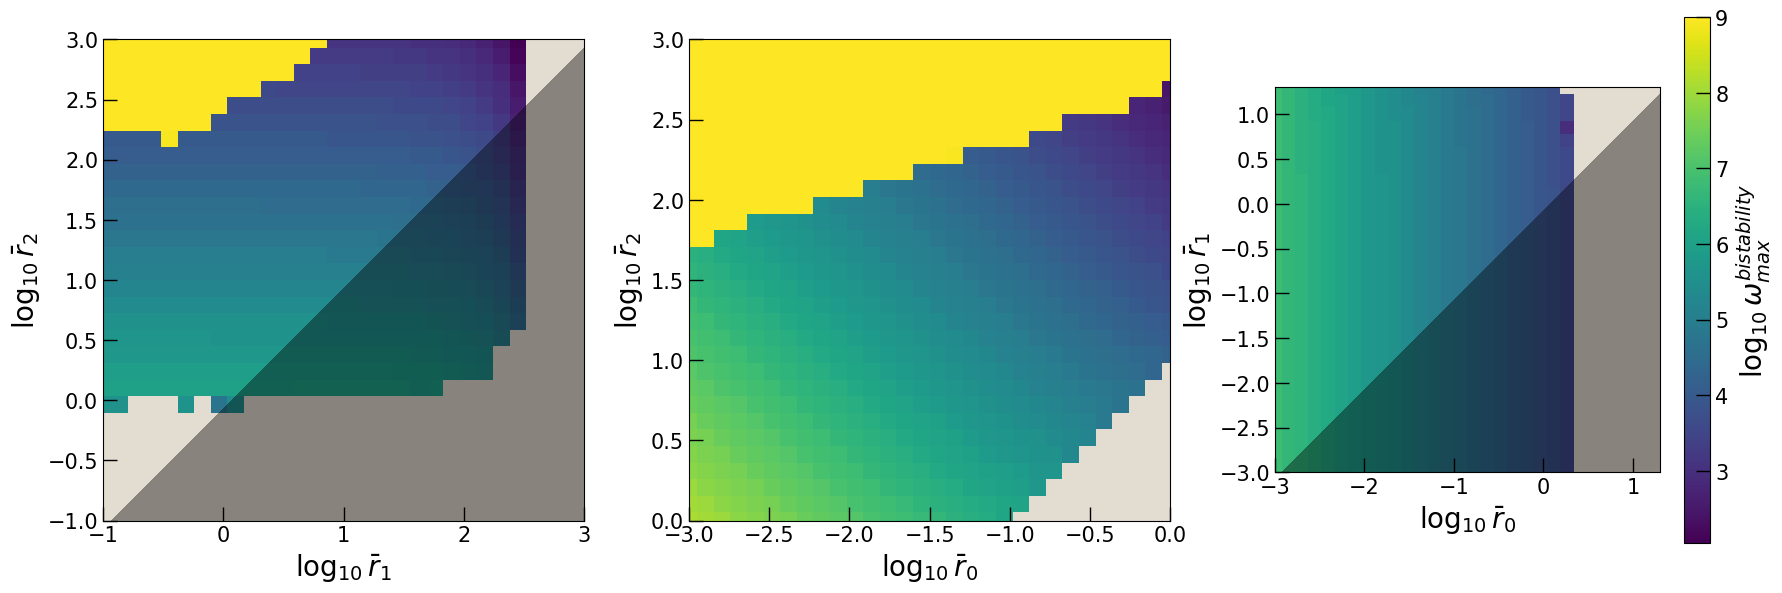

In [14]:
# Plot

fig,ax=plt.subplots(1,3,figsize=(18,6))

shrink_cbar = 1

pcm0=ax[0].pcolormesh(np.log10(r1_values_r2), np.log10(r2_values_r1), np.transpose(np.log10(w_max_r1_r2)), vmin = min_w_max, vmax = max_w_max, rasterized=True)
ax[0].set_xlim([min(np.log10(r1_values_r2)),max(np.log10(r1_values_r2))])
ax[0].set_ylim([min(np.log10(r2_values_r1)),max(np.log10(r2_values_r1))])
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[0].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R1, R2 = np.meshgrid(np.log10(r1_values_r2), np.log10(r2_values_r1))
mask1 = R1 > R2 
mask2 = R1 < np.log10(fixed_r0) 
mask = mask1 | mask2
ax[0].contourf(R1, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)
ax[0].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[0].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)

pcm1=ax[1].pcolormesh(np.log10(r0_values_r2), np.log10(r2_values_r0), np.transpose(np.log10(w_max_r0_r2)), vmin = min_w_max, vmax = max_w_max, rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_xlim([min(np.log10(r0_values_r2)),max(np.log10(r0_values_r2))])
ax[1].set_ylim([min(np.log10(r2_values_r0)),max(np.log10(r2_values_r0))])
#mask to shade region where the system does not behave like an auto-activation system
R0, R2 = np.meshgrid(np.log10(r0_values_r2), np.log10(r2_values_r0))
mask1 = np.log10(fixed_r1) > R2 
mask2 = R0 > np.log10(fixed_r1) 
mask = mask1 | mask2
ax[1].contourf(R0, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)
ax[1].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[1].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)


pcm2=ax[2].pcolormesh(np.log10(r0_values_r1), np.log10(r1_values_r0), np.transpose(np.log10(w_max_r0_r1)),vmin = min_w_max, vmax = max_w_max, rasterized=True)
ax[2].set_ylim([min(np.log10(r1_values_r0)),max(np.log10(r1_values_r0))])
ax[2].set_xlim([min(np.log10(r0_values_r1)),max(np.log10(r0_values_r1))])
ax[2].set_aspect('equal')
ax[2].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[2].set_ylabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R1, R0 = np.meshgrid(np.log10(r1_values_r0), np.log10(r0_values_r1))
mask1 = R1 > np.log10(fixed_r2)
mask2 = R1 < R0  
mask = mask1 | mask2
ax[2].contourf(R0, R1, mask, levels=[0.5, 1], colors='black', alpha=0.4)

cbar = fig.colorbar(pcm2, ax=ax[2], shrink = shrink_cbar)
cbar.set_label(r'$\log_{10}\omega_{max}^{bistability}$', fontsize=s)

plt.tight_layout()
plt.show()

# Fig. 32 (B)-(D)

This figure performs several two-dimensional parameter sweeps -- $(\bar{r}_1, \bar{r}_2)$, $(\bar{r}_0,\bar{r}_2)$, and $(\bar{r}_0, \bar{r}_1)$ -- and for each sweep generates heatmaps defining the minimum values of cooperativity for which the system can exhibit bistability. Specifically, for each type of sweep, we plot heatmaps for (B) minimal cooperativity values $\omega_{\rm min}^{\rm bistability}$, (C) the corresponding effective Hill coefficient, and (D) an effective cooperativity measured from the necessary condition for bistability (derived in the paper) that $\omega\bar{r}_{2}/2 > 1$.

### Computing the minimal values of cooperativity for which there is bistability:

In [16]:
n_sample=30
s=20
lim =3
r0_values_r2=np.logspace(- lim,np.log10(fixed_r1),n_sample)
r2_values_r0=np.logspace(np.log10(fixed_r1),lim,n_sample)

r1_values_r2=np.logspace(np.log10(fixed_r0),lim,n_sample)
r2_values_r1=np.logspace(np.log10(fixed_r0),lim,n_sample)

r1_values_r0=np.logspace(-lim,np.log10(fixed_r2),n_sample)
r0_values_r1=np.logspace(-lim,np.log10(fixed_r2),n_sample)

w_values = np.logspace(0,9,100)

w_min_r1_r2, w_max_r1_r2 = w_bifurcation_r2_r1_pact(p_values, fixed_r0, r1_values_r2, r2_values_r1, w_values)

w_min_r0_r2, w_max_r0_r2 = w_bifurcation_r2_r0_pact(p_values, fixed_r1, r0_values_r2, r2_values_r0, w_values)

w_min_r0_r1, w_max_r0_r1 = w_bifurcation_r0_r1_pact(p_values, fixed_r2, r0_values_r1, r1_values_r0, w_values)

max1_max, max2_max, max3_max = np.log10(np.nanmax(w_max_r1_r2)), np.log10(np.nanmax(w_max_r0_r2)), np.log10(np.nanmax(w_max_r0_r1))
min1_max, min2_max, min3_max = np.log10(np.nanmin(w_max_r1_r2)), np.log10(np.nanmin(w_max_r0_r2)), np.log10(np.nanmin(w_max_r0_r1))
max_w_max = max(max1_max, max2_max, max3_max)
min_w_max = min(min1_max, min2_max, min3_max)

In [17]:
max1, max2, max3 = np.log10(np.nanmax(w_min_r1_r2)), np.log10(np.nanmax(w_min_r0_r2)), np.log10(np.nanmax(w_min_r0_r1))
min1, min2, min3 = np.log10(np.nanmin(w_min_r1_r2)), np.log10(np.nanmin(w_min_r0_r2)), np.log10(np.nanmin(w_min_r0_r1))
max_w_min = max(max1, max2, max3)
min_w_min = min(min1, min2, min3)

### Computing the minimum effective Hill coefficient for which there is bistability, $\omega_{min}^{bistability}$:

In [19]:
n_eff_min_r0_r1=np.full((len(r0_values_r1), len(r1_values_r0)),np.nan)
n_eff_min_r0_r2=np.full((len(r0_values_r2), len(r2_values_r0)),np.nan)
n_eff_min_r1_r2=np.full((len(r1_values_r2), len(r2_values_r1)),np.nan)

for i in range(len(r0_values_r1)):
  for j in range(len(r1_values_r0)):
    r0=r0_values_r1[i]
    r1=r1_values_r0[j]
    if not np.isnan(w_min_r0_r1[i,j]):
      ww=w_min_r0_r1[i,j]
      n_eff_min_r0_r1[i,j]=n_eff(r0, r1, fixed_r2, ww)

for i in range(len(r0_values_r2)):
  for j in range(len(r2_values_r0)):
    r0=r0_values_r2[i]
    r2=r2_values_r0[j]
    if not np.isnan(w_min_r0_r2[i,j]):
      ww=w_min_r0_r2[i,j]
      n_eff_min_r0_r2[i,j]=n_eff(r0, fixed_r1, r2, ww)

for i in range(len(r1_values_r2)):
  for j in range(len(r2_values_r1)):
    r1=r1_values_r2[i]
    r2=r2_values_r1[j]
    if not np.isnan(w_min_r1_r2[i,j]):
      ww=w_min_r1_r2[i,j]
      n_eff_min_r1_r2[i,j]=n_eff(fixed_r0, r1, r2, ww)

 Define several plotting variables:

In [21]:
n_max1, n_max2, n_max3 = np.nanmax(n_eff_min_r0_r1), np.nanmax(n_eff_min_r0_r2), np.nanmax(n_eff_min_r1_r2)
n_min1, n_min2, n_min3 = np.nanmin(n_eff_min_r0_r1), np.nanmin(n_eff_min_r0_r2), np.nanmin(n_eff_min_r1_r2)
max_n_min = max(n_max1, n_max2, n_max3)
min_n_min = min(n_min1, n_min2, n_min3)

In [22]:
L1=np.log10(np.transpose(w_min_r1_r2*r2_values_r1/2))
L2=np.log10(np.transpose(w_min_r0_r2*r2_values_r0/2))
L3=np.log10(np.transpose(w_min_r0_r1*fixed_r2/2))

d_max1, d_max2, d_max3 = np.nanmax(L1), np.nanmax(L2), np.nanmax(L3)
d_min1, d_min2, d_min3 = np.nanmin(L1), np.nanmin(L2), np.nanmin(L3)
max_d_min = max(d_max1, d_max2, d_max3)
min_d_min = min(d_min1, d_min2, d_min3)

## Panels (B)-(D)(i): $\omega_{min}^{bistability}$ in the $(\bar{r}_0, \bar{r}_1)$ space

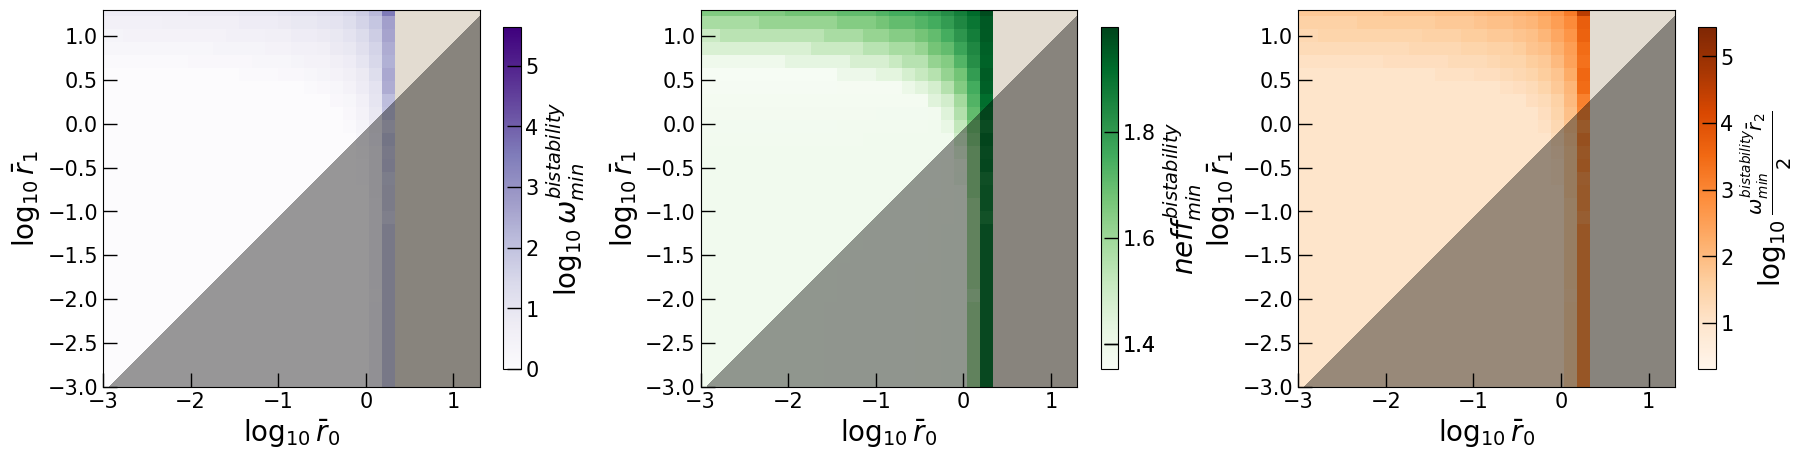

In [24]:
fig,ax=plt.subplots(1,3,figsize=(18,6))

shrink_cbar = 0.6

pcm0=ax[0].pcolormesh(np.log10(r0_values_r1), np.log10(r1_values_r0), np.transpose(np.log10(w_min_r0_r1)),vmin = min_w_min, vmax = max_w_min, cmap = 'Purples')
ax[0].set_ylim([min(np.log10(r1_values_r0)),max(np.log10(r1_values_r0))])
ax[0].set_xlim([min(np.log10(r0_values_r1)),max(np.log10(r0_values_r1))])
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[0].set_ylabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R1, R0 = np.meshgrid(np.log10(r1_values_r0), np.log10(r0_values_r1))
mask1 = R1 > np.log10(fixed_r2) 
mask2 = R1 < R0 
mask = mask1 | mask2
ax[0].contourf(R0, R1, mask, levels=[0.5, 1], colors='black', alpha=0.4)


cbar = fig.colorbar(pcm0, ax=ax[0], shrink = shrink_cbar)
cbar.set_label(r'$\log_{10}\omega_{min}^{bistability}$', fontsize=s)

pcm3=ax[1].pcolormesh(np.log10(r0_values_r1), np.log10(r1_values_r0), np.transpose(n_eff_min_r0_r1), vmin = min_n_min, vmax = max_n_min, cmap = 'Greens')
ax[1].set_ylim([min(np.log10(r1_values_r0)),max(np.log10(r1_values_r0))])
ax[1].set_xlim([min(np.log10(r0_values_r1)),max(np.log10(r0_values_r1))])
ax[1].set_aspect('equal')
ax[1].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[1].set_ylabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R1, R0 = np.meshgrid(np.log10(r1_values_r0), np.log10(r0_values_r1))
mask1 = R1 > np.log10(fixed_r2)  
mask2 = R1 < R0  
mask = mask1 | mask2
ax[1].contourf(R0, R1, mask, levels=[0.5, 1], colors='black', alpha=0.4)

cbar = fig.colorbar(pcm3, ax=ax[1], shrink = shrink_cbar)
cbar.set_label(r'$neff_{min}^{bistability}$', fontsize=s)
custom_ticks=[1.40,1.4,1.6,1.8]
cbar.set_ticks(custom_ticks)

pcm4=ax[2].pcolormesh(np.log10(r0_values_r1), np.log10(r1_values_r0), np.log10(np.transpose(w_min_r0_r1*fixed_r2/2)), vmin = min_d_min, vmax = max_d_min, cmap = 'Oranges')
ax[2].set_ylim([min(np.log10(r1_values_r0)),max(np.log10(r1_values_r0))])
ax[2].set_xlim([min(np.log10(r0_values_r1)),max(np.log10(r0_values_r1))])
ax[2].set_aspect('equal')
ax[2].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[2].set_ylabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R1, R0 = np.meshgrid(np.log10(r1_values_r0), np.log10(r0_values_r1))
mask1 = R1 > np.log10(fixed_r2)  
mask2 = R1 < R0  
mask = mask1 | mask2
ax[2].contourf(R0, R1, mask, levels=[0.5, 1], colors='black', alpha=0.4)


cbar = fig.colorbar(pcm4, ax=ax[2], shrink = shrink_cbar)
cbar.set_label(r'$\log_{10}\frac{\omega_{min}^{bistability}\bar{r}_2}{2}$', fontsize=s)


plt.tight_layout()
plt.show()

## Panels (B)-(D)(ii):  $\omega_{min}^{bistability}$ in the $(\bar{r}_1, \bar{r}_2)$ space

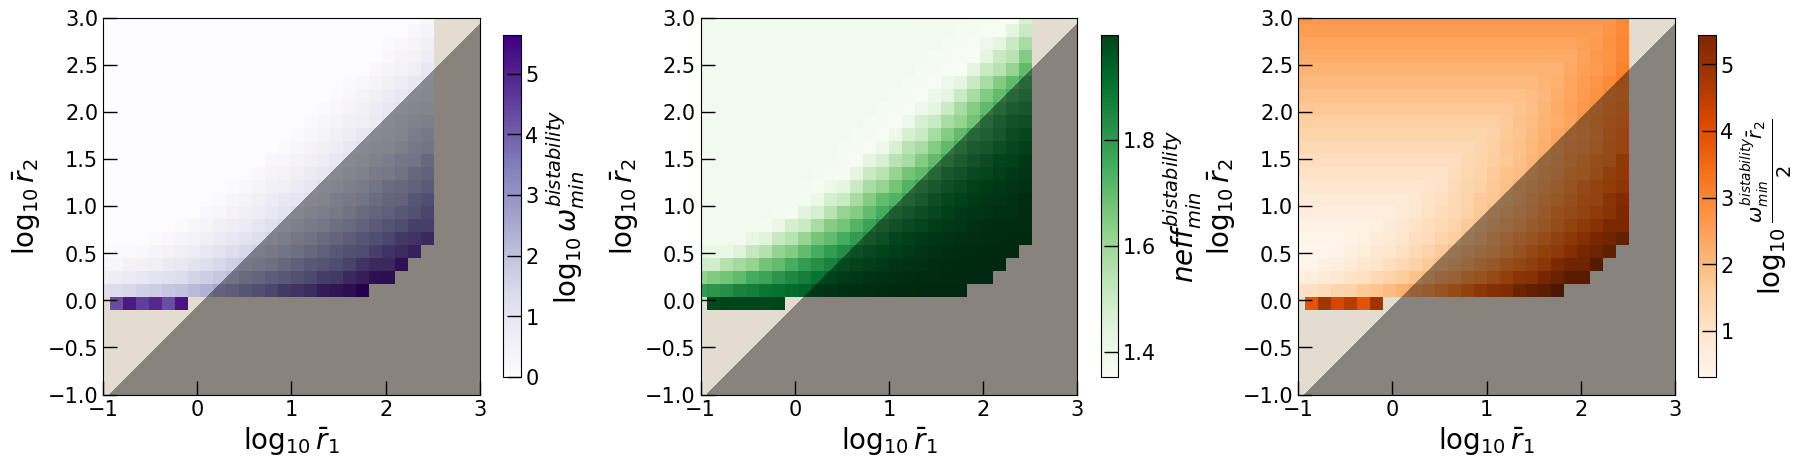

In [26]:
fig,ax=plt.subplots(1,3,figsize=(18,6))

shrink_cbar = 0.6

pcm0=ax[0].pcolormesh(np.log10(r1_values_r2), np.log10(r2_values_r1), np.transpose(np.log10(w_min_r1_r2)), vmin = min_w_min, vmax = max_w_min, cmap = 'Purples')
ax[0].set_xlim([min(np.log10(r1_values_r2)),max(np.log10(r1_values_r2))])
ax[0].set_ylim([min(np.log10(r2_values_r1)),max(np.log10(r2_values_r1))])
ax[0].set_aspect('equal')
ax[0].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[0].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R1, R2 = np.meshgrid(np.log10(r1_values_r2), np.log10(r2_values_r1))
mask1 = R1 > R2 
mask2 = R1 < np.log10(fixed_r0) 
mask = mask1 | mask2
ax[0].contourf(R1, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)
ax[0].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[0].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)


cbar = fig.colorbar(pcm0, ax=ax[0], shrink = shrink_cbar)
cbar.set_label(r'$\log_{10}\omega_{min}^{bistability}$', fontsize=s)

pcm3=ax[1].pcolormesh(np.log10(r1_values_r2), np.log10(r2_values_r1), np.transpose(n_eff_min_r1_r2), vmin = min_n_min, vmax = max_n_min, cmap = 'Greens')
ax[1].set_xlim([min(np.log10(r1_values_r2)),max(np.log10(r1_values_r2))])
ax[1].set_ylim([min(np.log10(r2_values_r1)),max(np.log10(r2_values_r1))])
ax[1].set_aspect('equal')
ax[1].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[1].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R1, R2 = np.meshgrid(np.log10(r1_values_r2), np.log10(r2_values_r1))
mask1 = R1 > R2 
mask2 = R1 < np.log10(fixed_r0) 
mask = mask1 | mask2
ax[1].contourf(R1, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)
ax[1].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[1].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)


cbar = fig.colorbar(pcm3, ax=ax[1], shrink = shrink_cbar)
cbar.set_label(r'$neff_{min}^{bistability}$', fontsize=s)
custom_ticks=[1.4,1.6,1.8]
cbar.set_ticks(custom_ticks)

pcm4=ax[2].pcolormesh(np.log10(r1_values_r2), np.log10(r2_values_r1), np.log10(np.transpose(w_min_r1_r2*r2_values_r1/2)), vmin = min_d_min, vmax = max_d_min, cmap = 'Oranges')
ax[2].set_xlim([min(np.log10(r1_values_r2)),max(np.log10(r1_values_r2))])
ax[2].set_ylim([min(np.log10(r2_values_r1)),max(np.log10(r2_values_r1))])
ax[2].set_aspect('equal')
ax[2].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[2].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)

#mask to shade region where the system does not behave like an auto-activation system
R1, R2 = np.meshgrid(np.log10(r1_values_r2), np.log10(r2_values_r1))
mask1 = R1 > R2 
mask2 = R1 < np.log10(fixed_r0)
mask = mask1 | mask2
ax[2].contourf(R1, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)
ax[2].set_xlabel(r'$\log_{10}\bar{r}_1$', fontsize=s)
ax[2].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)


cbar = fig.colorbar(pcm4, ax=ax[2], shrink = shrink_cbar)
cbar.set_label(r'$\log_{10}\frac{\omega_{min}^{bistability}\bar{r}_2}{2}$', fontsize=s)

plt.tight_layout()
plt.show()

## Panels (B)-(D)(iii): $\omega_{min}^{bistability}$ in the $(\bar{r}_0, \bar{r}_2)$ space

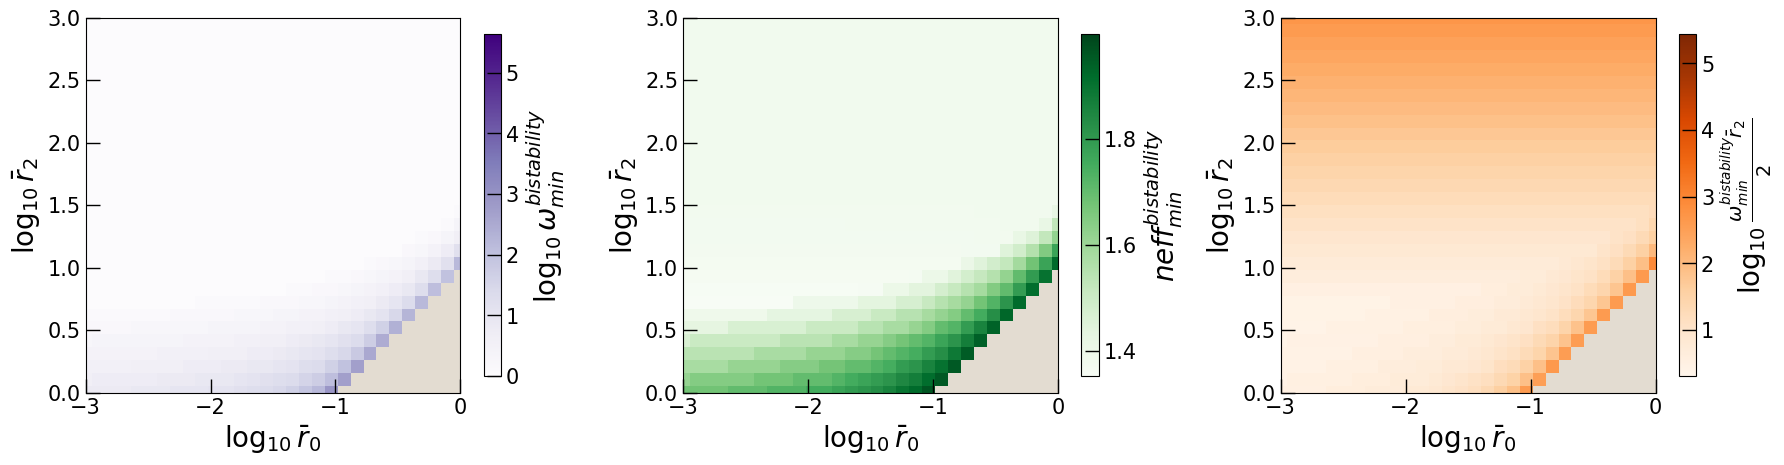

In [28]:
fig,ax=plt.subplots(1,3,figsize=(18,6))

shrink_cbar = 0.6

pcm0=ax[0].pcolormesh(np.log10(r0_values_r2), np.log10(r2_values_r0), np.transpose(np.log10(w_min_r0_r2)), vmin = min_w_min, vmax = max_w_min, cmap = 'Purples')
ax[0].set_aspect('equal')
ax[0].set_xlim([min(np.log10(r0_values_r2)),max(np.log10(r0_values_r2))])
ax[0].set_ylim([min(np.log10(r2_values_r0)),max(np.log10(r2_values_r0))])
#mask to shade region where the system does not behave like an auto-activation system
R0, R2 = np.meshgrid(np.log10(r0_values_r2), np.log10(r2_values_r0))
mask1 = np.log10(fixed_r1) > R2 
mask2 = R0 > np.log10(fixed_r1)  
mask = mask1 | mask2
ax[0].contourf(R0, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)
ax[0].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[0].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)


cbar = fig.colorbar(pcm0, ax=ax[0], shrink = shrink_cbar)
cbar.set_label(r'$\log_{10}\omega_{min}^{bistability}$', fontsize=s)

pcm3=ax[1].pcolormesh(np.log10(r0_values_r2), np.log10(r2_values_r0), np.transpose(n_eff_min_r0_r2), vmin = min_n_min, vmax = max_n_min, cmap = 'Greens')
ax[1].set_aspect('equal')
ax[1].set_xlim([min(np.log10(r0_values_r2)),max(np.log10(r0_values_r2))])
ax[1].set_ylim([min(np.log10(r2_values_r0)),max(np.log10(r2_values_r0))])
ax[1].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[1].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R0, R2 = np.meshgrid(np.log10(r0_values_r2), np.log10(r2_values_r0))
mask1 = np.log10(fixed_r1) > R2
mask2 = R0 > np.log10(fixed_r1)  
mask = mask1 | mask2
ax[1].contourf(R0, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)


cbar = fig.colorbar(pcm3, ax=ax[1], shrink = shrink_cbar)
cbar.set_label(r'$neff_{min}^{bistability}$', fontsize=s)
custom_ticks=[1.4,1.6,1.8]
cbar.set_ticks(custom_ticks)

pcm4=ax[2].pcolormesh(np.log10(r0_values_r2), np.log10(r2_values_r0), np.log10(np.transpose(w_min_r0_r2*r2_values_r0/2)), vmin = min_d_min, vmax = max_d_min, cmap = 'Oranges')
ax[2].set_xlim([min(np.log10(r0_values_r2)),max(np.log10(r0_values_r2))])
ax[2].set_ylim([min(np.log10(r2_values_r0)),max(np.log10(r2_values_r0))])
ax[2].set_aspect('equal')
ax[2].set_xlabel(r'$\log_{10}\bar{r}_0$', fontsize=s)
ax[2].set_ylabel(r'$\log_{10}\bar{r}_2$', fontsize=s)
#mask to shade region where the system does not behave like an auto-activation system
R0, R2 = np.meshgrid(np.log10(r0_values_r2), np.log10(r2_values_r0))
mask1 = np.log10(fixed_r1) > R2  
mask2 = R0 > np.log10(fixed_r1) 
mask = mask1 | mask2
ax[2].contourf(R0, R2, mask, levels=[0.5, 1], colors='black', alpha=0.4)

cbar = fig.colorbar(pcm4, ax=ax[2], shrink = shrink_cbar)
cbar.set_label(r'$\log_{10}\frac{\omega_{min}^{bistability}\bar{r}_2}{2}$', fontsize=s)

plt.tight_layout()
plt.show()